---
layout: post
title: Speeding up CRC-32 calculations in Mojo 
categories: [mojo]
date: "2024-10-05"
author: "Ferdinand Schenck"
draft: false
description: Or how I made CRC-32 calculations 500 times faster than Python, and 3 times slower than Python. 
---

In a [previous post](https://fnands.com/blog/2024/mojo-png-parsing/) on parsing PNG images in I very briefly mentioned cyclic redundancy checks, and posted a rather cryptic looking function which I claimed was a bit inefficient. 

In this post I want to follow up on that a bit and see how we can speed up these calculations.    

For reference, this post was done with Mojo 24.5, so a few language details have changed since my last post (e.g. `math.bit` got moved to the top-level `bit` and a few of it's functions have been renamed). 

I actually wrote most of this post in June with Mojo 24.4, but ran into a bit of an [issue](https://github.com/modularml/mojo/issues/3065) which has now been resolved. It even resulted in a [new unit test](https://github.com/modularml/mojo/commit/4a5c21fccb2bfde1d8408c991856de6a098e504a) for Mojo, so thanks to [Laszlo Kindrat](https://github.com/laszlokindrat) for fixing the issue, and for [soraros](https://github.com/soraros) and [martinvuyk](https://github.com/martinvuyk) for helping figure out what the actual issue was. 


## A bit of context
But first, let's go through a bit of background so we know what we're dealing with. 

### Cyclic redundancy checks

CRCs are error detecting codes that are often used to detect corruption of data in digital files, an example of which is PNG files. In the case of PNGs for example the CRC-32 is calculated for the data of each chunk and appended to the end of the chunk, so that the person reading the file can verify whether the data they read was the same as the data that was written.  

A CRC check technically does "long division in the ring of polynomials of binary coefficients ($\Bbb{F}_2[x]$)" 😳.   

It's not as complicated as it sounds. I found the [Wikipedia article on Polynomial long division](https://en.wikipedia.org/wiki/Polynomial_long_division) to be helpful, and if you want an in depth explanation then
[this post](https://github.com/komrad36/CRC) by [Kareem Omar](https://github.com/komrad36) does an excellent job of explaining both the concept and implementation considerations. I won't go deep into the explanations, so I recommend you read at least the first part of Kareem's post for more background. I pretty much use his post as a guide. 

Did you read that post? Then welcome back, and well continue from there. 

But tl;dr: 
XOR is equivalent to polynomial long division (over a finite field) for binary numbers, and XOR is a very efficient operation to calculate. 
Essentially what a CRC check does in practice is to run through a sequence of bytes, and iteratively perform a lot of XORs and bit-shifts. By iteratively going through each bit, one can come up with a value that will (nearly certainly) change if data is corrupted somehow. 

## The original 

The CRC-32 check from my previous post looked something like this: 

In [1]:
from bit import bit_reverse

fn CRC32(data: List[UInt8], dummy_table: List[UInt32]) -> UInt32:
    var crc32: UInt32 = 0xffffffff
    for byte in data:
        crc32 = (bit_reverse(byte[]).cast[DType.uint32]() << 24) ^ crc32
        for _ in range(8):
            
            if crc32 & 0x80000000 != 0:
                crc32 = (crc32 << 1) ^ 0x04c11db7
            else:
                crc32 = crc32 << 1
                
    return bit_reverse(crc32^0xffffffff)

I'll step through this in a moment, but the first thing you might notice here is that I am reversing a lot of bits here. The table argument is a bit of future proofing, which we won't need for now, but will become apparent soon. Just ignore it for now. 


This is because when I was implementing this function (based off a C example), I implemented a little-endian version of the algorithm, while PNGs are encoded as big-endian. It's not a huge deal, but it does mean that I am constantly reversing bytes, and then reversing the output again.

## The correct bit order


We can make this better by implementing the big-endian version:

In [2]:
fn CRC32_inv(data: List[UInt8], dummy_table: List[UInt32]) -> UInt32:
    """Big endian CRC-32 check using 0xedb88320 as polynomial."""

    # Initialize crc32 as all 1s
    var crc32: UInt32 = 0xffffffff

    # Step though all bytes in bytestream
    for byte in data:

        # XOR new byte with crc32 
        # We need to cast it to a UInt32 first as Mojo doesn't do implicit casts
        crc32 = (byte[].cast[DType.uint32]() ) ^ crc32

        # Step though crc32 8 times
        for _ in range(8):
            
            # If leading bit is 1, bitshift by 1 and XOR with the generator polynomial
            # otherwise just shift by one 
            if crc32 & 1 != 0:
                crc32 = (crc32 >> 1) ^ 0xedb88320
            else:
                crc32 = crc32 >> 1

    # Invert upon return
    return crc32^0xffffffff

 This is very similar, and just entails that we use a the reverse of the polygon we did before (if you bit reverse `0x04c11db7` you get `0xedb88320`). This also saves us one 24-bit bit-shift, as we are now working on the bottom 8 bits of the `UInt32` instead of the top 8. 

 Just to verify that these implementations are equivalent, let's do a quick test: 

In [3]:
var example_list = List[UInt8](5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
                                           5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
                                           5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
                                           5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201, 
                                           5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
                                           5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
                                           5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
                                           5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201, 42)

print(hex(CRC32(example_list, List[UInt32](1))))
print(hex(CRC32_inv(example_list, List[UInt32](1))))                                           

0x382aa34e
0x382aa34e


And there we go, a more elegant version of the CRC-32 check I implemented last time.  

As the theme of today's post is trying to speed things up, let's do a little bit of benchmarking to see if this change has saved us any time. As we are doing one fewer bit reverse and bit shift per byte, as well as a final reverse, we should see a bit of a performance uplift. 


## A bit of benchmarking:


So let's define a benchmarking function. This function will take two version of the CRC32 function and benchmark their runtimes. 

We have to a little bit of work first. The functions we test need to return `None`, so we need to wrap our functions in functions with no return value. 
Note the `benchmark.keep(a)` calls: the compiler will realize that `a` is never used and will compile this away unless you instruct it to keep them: 

In [4]:
import benchmark
from testing import assert_equal

alias data_table_func = fn(data: List[UInt8], table: List[UInt32]) -> UInt32


fn wrap_func[testing_function: data_table_func, data: List[UInt8], table: List[UInt32] ]():
    var a =  testing_function(data = data, table = table)
    benchmark.keep(a)


fn bench[function_1: data_table_func, function_2: data_table_func,
         test_list: List[UInt8], test_table: List[UInt32]](quiet: Bool = False) raises -> Tuple[Float64, Float64, Float64]:


    var CRC32_1 = function_1(test_list, test_table) 

    alias function_1_wrapped = wrap_func[function_1]
    var report_1 = benchmark.run[function_1_wrapped[test_list, test_table]](max_runtime_secs=1.0
    ).mean(benchmark.Unit.ms)
    

    var CRC32_2 = function_2(test_list, test_table) 
    
    assert_equal(CRC32_1, CRC32_2)

    alias function_2_wrapped = wrap_func[function_2]
    var report_2 = benchmark.run[function_2_wrapped[test_list, test_table]](max_runtime_secs=1.0
    ).mean(benchmark.Unit.ms)

    var speedup = report_1/report_2

    if not quiet:
        print("Function 1 runtime (ms): \t", report_1)
        print("Function 2 runtime (ms): \t", report_2)
        print("Speedup factor: \t\t", (speedup))


    return report_1, report_2, speedup

Next we need a test case. I'm not sure if there is a nicer way to fill a List with random values yet, but for now we can list create an `UnsafePointer`, alloc some space, and fill it with random numbers using `rand`. 
Then we can init a `List` using that data: 

In [5]:
from random import rand

alias fill_size = 2**20
alias g = UnsafePointer[UInt8].alloc(fill_size)
rand[DType.uint8](g, fill_size)
alias rand_list = List[UInt8](unsafe_pointer = g, size = fill_size, capacity = fill_size)

alias dummy_table = List[UInt32](1)

And finally we are ready to benchmark: 

In [6]:
original_time, improved_time, speedup = bench[CRC32, CRC32_inv, rand_list, dummy_table]()

Function 1 runtime (ms): 	 9.437418430000001
Function 2 runtime (ms): 	 6.8247150400000001
Speedup factor: 		 1.3828296675666039


Nice! So just by avoiding a few bit reversals and bit shifts we get about a 30% uplift in performance depending on the run. 

**Note:** I am doing this in a Jupyter notebook, so there is a bit of variance from run to run. 


## A quick Python speed-check

While we're checking performance, let's see how this implementation would perform in Python: 

In [7]:
%%python

def py_crc32(data: bytearray) -> int: 
    crc32 = 0xffffffff
    
    for byte in data:
        crc32 = byte ^ crc32

        for i in range(8):
            if crc32 & 1 != 0:
                crc32 = (crc32 >> 1) ^ 0xedb88320
            else:
                crc32 = crc32 >> 1

    return crc32^0xffffffff

And let's just do a sanity check to assure ourselves that we produce the same CRC-32 value given the same bytestream: 

In [8]:
%%python

py_example_list = [5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
    5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
    5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
    5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201, 
    5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
    5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
    5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201,
    5, 78, 138, 1, 54, 172, 104, 99, 54, 167, 94, 56, 22, 184, 204, 90, 201, 42]
    
py_example_bytearray = bytearray(py_example_list)

print(hex(py_crc32(py_example_bytearray)))

0x382aa34e


In [9]:
%%python
from timeit import timeit
import numpy as np


py_rand_list = np.random.randint(0, 255, size=2**20, dtype=np.uint8)

naive_python_seconds = timeit(lambda: py_crc32(py_rand_list), number=10)/10

print(f"Naive Python runtime (ms): {naive_python_seconds*100}")

Naive Python runtime (ms): 123.02583360986318


That's pretty slow in fact this means that: 

In [10]:
print("Speedup over Python: Mojo is", (naive_python_seconds*100/improved_time), "faster")

Speedup over Python: Mojo is 18.026515816235925 faster


So that's a nice little speedup we can get by writing essentially the same logic in Mojo. 

Now this is a bit unfair. If you actually wrote the this function in Python for anything other than educational purposes, then you are using Python wrong, but I'll get back to how you would actually do it later. 



## Adding a table

Now, the majority of CRC-32 implementations you see will usually use a table. 

This is called the [Sarwate algorithm](https://en.wikipedia.org/wiki/Computation_of_cyclic_redundancy_checks#Sarwate_algorithm_(single_lookup_table)) and exploits the fact that as we are operating on data one byte at a time, there are only 256 unique values that the calculation in the inner loop of the algorithm can take. This is a small enough table (1024 bytes for 256 unsigned 32-bit integers) that it can easily be kept in the L1 cache during computation. 

Let's try it out to see how much faster this get's us.

First, we need to pre-compute the table: 

In [11]:

fn fill_table() -> List[UInt32]:
    var table = List[UInt32](capacity=256)
    for i in range(256):

        var key = UInt8(i)
        var crc32 = key.cast[DType.uint32]()
        for i in range(8):
            if crc32 & 1 != 0:
                crc32 = (crc32 >> 1) ^ 0xedb88320
            else:
                crc32 = crc32 >> 1

        table[i] = crc32
    return table

alias little_endian_table = fill_table()


We've now effectively amortized the cost of the inner loop and replaced it with a table lookup which should in principle be faster. 

Our CRC-32 algorithm now take this form: 

In [12]:
fn CRC32_table(data: List[UInt8], table: List[UInt32]) -> UInt32:
    var crc32: UInt32 = 0xffffffff
    
    for byte in data:
        var index = (crc32 ^ byte[].cast[DType.uint32]()) & 0xff
        crc32 = table[int(index)] ^ (crc32 >> 8)

    return crc32^0xffffffff

# Sanity check
print(hex(CRC32(example_list, List[UInt32](1))))
print(hex(CRC32_table(example_list, little_endian_table)))                                           

0x382aa34e
0x382aa34e


Now we can test it out! 

In [13]:
_, _, speedup_table = bench[CRC32, CRC32_table, rand_list, little_endian_table]()

Function 1 runtime (ms): 	 8.5761109999999992
Function 2 runtime (ms): 	 1.9543971584601614
Speedup factor: 		 4.3881106574863127


So a speedup of around 4-5 times as fast as when we started. This is already a pretty good result, but can we do better? 

## Two byte table

In principle, we could load the data as a 16-bit integer at a time and use the same trick above to build a table. However, such a table would have 65536 entries, resulting in a 256 KB table, which is a lot bigger than the 48 KB of L1 cache on my machine. 


It turns out, we can still [do two bytes at a time](https://en.wikipedia.org/wiki/Computation_of_cyclic_redundancy_checks#Byte-Slicing_using_multiple_tables).  

Following the [description given by Kareem Omar](https://github.com/komrad36/CRC?tab=readme-ov-file#option-6-1-byte-tabular), we realize that if we have two successive bytes in our message, let's call them `X` and `Y`: 

```
X = xxxxxxxx
Y = yyyyyyyy
```

if we pad these messages with zeroes

```
Xz = xxxxxxxx00000000
zY = 00000000yyyyyyyy
```

then 

```
Xz ^ zY = xxxxxxxxyyyyyyyy = M
```

What this means is that if we have a CRC algorithm that works on a 16-bit message called M then: 

```
CRC(M) = CRC(Xz ^ zY) = CRC(Xz) ^ CRC(zY) 
```

For the operation on `Y`, leading zeros don't affect the calculation, so we can just use the 8-bit CRC algorithm we have developed above: 

```
CRC(zY) = CRC(Y)
```

The same does not hold for trailing zeroes. However, as `Xz` will always be of the form `xxxxxxxx00000000` and there can only be 256 unique values for `Xz`, we can build a new table with 256 entries to look up these values. We can build two separate 256 entry tables, or we can just build one 512 entry table, 


So let's construct this new table: 

In [14]:
fn fill_table_2_byte() -> List[UInt32]:

    var table = List[UInt32](capacity=512)
    table.size = 512
    table.resize(256*2, 0)

    for i in range(256):

        var key = UInt8(i)
        var crc32 = key.cast[DType.uint32]()
        for i in range(8):
            if crc32 & 1 != 0:
                crc32 = (crc32 >> 1) ^ 0xedb88320
            else:
                crc32 = crc32 >> 1

        table[i] = crc32

    for i in range(256, 512):
        var crc32 = table[i-256]
        table[i] = (crc32 >> 8) ^ table[int(crc32.cast[DType.uint8]())]
    return table

var little_endian_table_2_byte = fill_table_2_byte()


We have to now update our algorithm to do two table lookups instead of one. 

Additionally, we have to modify our algorithm to read the data two bytes at a time. 



In [15]:
fn CRC32_table_2_byte(data: List[UInt8], table: List[UInt32]) -> UInt32:
    var crc32: UInt32 = 0xffffffff

    var length = len(data)//2
    var extra = len(data) % 2

    # Go through range in steps of 2
    for i in range(start = 0, end = length * 2 , step = 2):
        
        # Concatenate the two bytes
        var val: UInt32 = ((data[i + 1].cast[DType.uint32]() << 8) | data[i].cast[DType.uint32]())
        # Creat index, and look up values in table
        var index = crc32 ^ val
        crc32 =  table[int((index >> 8).cast[DType.uint8]())] ^ table[256 + int(index.cast[DType.uint8]())] ^ (crc32 >> 16)

    # Tail call to calculate final byte in case message not divisable by 2
    for i in range(2*length, 2*length + extra ):
        var index = (crc32 ^ data[i].cast[DType.uint32]()) & 0xff
        crc32 = table[int(index)] ^ (crc32 >> 8)


    return crc32^0xffffffff

# Sanity check
print(hex(CRC32(example_list, List[UInt32](1))))
print(hex(CRC32_table_2_byte(example_list, little_endian_table_2_byte)))

0x382aa34e
0x382aa34e


So let's see if this speeds things up: 

In [16]:
alias a_little_endian_table_2_byte = fill_table_2_byte()


_, _, speedup_table_2 = bench[CRC32, CRC32_table_2_byte, rand_list, a_little_endian_table_2_byte]()

Function 1 runtime (ms): 	 9.4386268461538467
Function 2 runtime (ms): 	 1.2856673344847436
Speedup factor: 		 7.3414223049670637


Nice, now we are at an around 7x speedup to where we began.

But can we go further? There's nothing in the above that forces us to only use two bytes at a time. 



## 4-bytes tabular

Nothing stops us from doing 4 bytes, i.e. 32-bits at a time with similar logic to above. 

I'll quickly create a function that will fill an arbitrarily sized table: 

In [17]:
fn fill_table_n_byte[n: Int]() -> List[UInt32]:
    var table = List[UInt32](capacity=256 * n)
    table.size = 256*n

    for i in range(256 * n):
        if i < 256:
            var key = UInt8(i)
            var crc32 = key.cast[DType.uint32]()
            for _ in range(8):
                if crc32 & 1 != 0:
                    crc32 = (crc32 >> 1) ^ 0xEDB88320
                else:
                    crc32 = crc32 >> 1

            table[i] = crc32
        else:
            var crc32 = table[i - 256]
            var index = int(crc32.cast[DType.uint8]())
            table[i] = (crc32 >> 8) ^ table[index]

    return table

var little_endian_table_4_byte = fill_table_n_byte[4]()

Now to create the 4-byte function: 

In [18]:
fn CRC32_table_4_byte(data: List[UInt8], table: List[UInt32]) -> UInt32:
    var crc32: UInt32 = 0xffffffff

    var size = 4

    var length = len(data)//size
    var extra = len(data) % size

    for i in range(start = 0, end = length*size, step = size):
        
        var val: UInt32 =  (data[i + 3].cast[DType.uint32]() << 24) | (data[i + 2].cast[DType.uint32]() << 16) | (data[i + 1].cast[DType.uint32]() << 8) | data[i].cast[DType.uint32]()
        var index = crc32 ^ val.cast[DType.uint32]()
        crc32 = table[0*256 + int((index >> 24).cast[DType.uint8]())] ^
                table[1*256 + int((index >> 16).cast[DType.uint8]())] ^
                table[2*256 + int((index >> 8).cast[DType.uint8]())] ^
                table[3*256 + int((index >> 0).cast[DType.uint8]())] 
    
    for i in range(size*length, size*length + extra ):
        var index = (crc32 ^ data[i].cast[DType.uint32]()) & 0xff
        crc32 = table[int(index)] ^ (crc32 >> 8)


    return crc32^0xffffffff

# Sanity check
print(hex(CRC32(example_list, List[UInt32](1))))
print(hex(CRC32_table_4_byte(example_list, little_endian_table_4_byte)))

0x382aa34e
0x382aa34e


And presto, it still works!

Let's see how much faster we are now? 



In [19]:
alias a_little_endian_table_4_byte = fill_table_n_byte[4]()


_, _, _ = bench[CRC32, CRC32_table_4_byte, rand_list, a_little_endian_table_4_byte]()

Function 1 runtime (ms): 	 9.9107345799999997
Function 2 runtime (ms): 	 0.69239487
Speedup factor: 		 14.313703075240866


A 14 times speedup over where we started!


But why stop there? 



## n-bytes implementation

We can in principle explicitly write out version that take 8, 16 or however many bytes at time. This get's a little long-winded, so I'll write some generic functions to make functions of arbitrary size. 


In [20]:
fn CRC32_table_n_byte_compact[size: Int](data: List[UInt8], table: List[UInt32]) -> UInt32:
    var crc32: UInt32 = 0xFFFFFFFF

    alias step_size = 4 # Always smashing 4 bytes into an UInt32
    alias units = size // step_size

    var length = len(data) // size
    var extra = len(data) % size

    var n = 0

    for i in range(start=0, end=length * size, step=size):
        @parameter
        for j in range(units):
            var vals = (
                (data[i + j * step_size + 3].cast[DType.uint32]() << 24)
                | (data[i + j * step_size + 2].cast[DType.uint32]() << 16)
                | (data[i + j * step_size + 1].cast[DType.uint32]() << 8)
                | (data[i + j * step_size + 0].cast[DType.uint32]() << 0)
            )

            if j == 0:
                vals = vals ^ crc32
                crc32 = 0 
        

            n = size - j * step_size
            crc32 = (
                table[(n - 4) * 256 + int((vals >> 24).cast[DType.uint8]())]
                ^ table[(n - 3) * 256 + int((vals >> 16).cast[DType.uint8]())]
                ^ table[(n - 2) * 256 + int((vals >> 8).cast[DType.uint8]())]
                ^ table[(n - 1) * 256 + int((vals >> 0).cast[DType.uint8]())]     
            ) ^ crc32
            

    for i in range(size * length, size * length + extra):
        var index = (crc32 ^ data[i].cast[DType.uint32]()) & 0xFF
        crc32 = table[int(index)] ^ (crc32 >> 8)

    return crc32 ^ 0xFFFFFFFF

Let's do a quick sanity check to see if this works: 

In [21]:
print(hex(CRC32(example_list, List[UInt32](1))))
print(hex(CRC32_table_n_byte_compact[4](example_list, little_endian_table_4_byte)))


0x382aa34e
0x382aa34e


## How big can we go? 

Let's try and increase the table size as far as we can. We'll go up in powers of two, and see how far we can go.

In [22]:
alias a_little_endian_table_4_byte = fill_table_n_byte[4]()

_, _, speedup_table_4 = bench[CRC32, CRC32_table_n_byte_compact[4], rand_list, a_little_endian_table_4_byte]()

Function 1 runtime (ms): 	 9.5889589700000002
Function 2 runtime (ms): 	 0.69029748700000004
Speedup factor: 		 13.891052988868841


In [23]:

_, _, speedup_table_8 = bench[CRC32, CRC32_table_n_byte_compact[8], rand_list, fill_table_n_byte[8]()]()

Function 1 runtime (ms): 	 10.002244664999999
Function 2 runtime (ms): 	 0.48423754050000001
Speedup factor: 		 20.655657251753283


In [24]:
_, _, speedup_table_16 = bench[CRC32, CRC32_table_n_byte_compact[16], rand_list, fill_table_n_byte[16]()]()

Function 1 runtime (ms): 	 9.065976534999999
Function 2 runtime (ms): 	 0.3490761703607127
Speedup factor: 		 25.971341800936472


In [25]:
_, _, speedup_table_32 = bench[CRC32, CRC32_table_n_byte_compact[32], rand_list, fill_table_n_byte[32]()]()

Function 1 runtime (ms): 	 9.6776499699999992
Function 2 runtime (ms): 	 0.22259112022425251
Speedup factor: 		 43.477250845631744


In [26]:
_, _, speedup_table_64 = bench[CRC32, CRC32_table_n_byte_compact[64], rand_list, fill_table_n_byte[64]()]()

Function 1 runtime (ms): 	 9.1518207500000006
Function 2 runtime (ms): 	 0.29884062938339201
Speedup factor: 		 30.6244193397774


In [27]:
_, _, speedup_table_128 = bench[CRC32, CRC32_table_n_byte_compact[128], rand_list, fill_table_n_byte[128]()]()

Function 1 runtime (ms): 	 9.4991627550000004
Function 2 runtime (ms): 	 0.53072807599999994
Speedup factor: 		 17.898361109126629


And there it is. At least on my machine, 32 bytes is the limit, maxing out at a roughly 40 times speedup over the naive implementation. After that we start to see a performance decrease.

Let's plot this to see the trend:

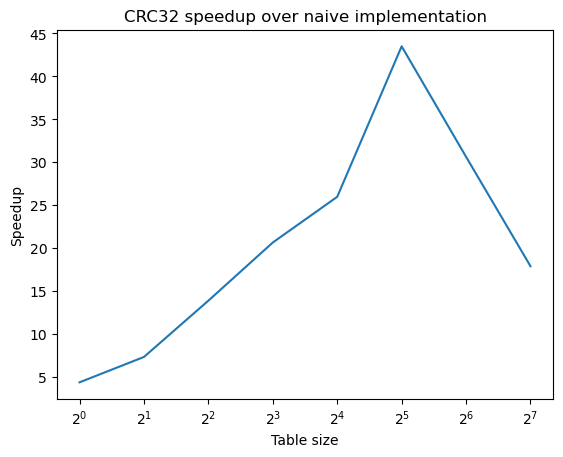

In [28]:
#| code-fold: true
from python import Python
var np = Python.import_module("numpy")
var plt = Python.import_module("matplotlib.pyplot")
var logging = Python.import_module("logging")
logging.getLogger('matplotlib.font_manager').disabled = True

plt.plot([1, 2, 4, 8, 16, 32, 64, 128], [speedup_table, speedup_table_2, speedup_table_4, speedup_table_8, speedup_table_16, speedup_table_32, speedup_table_64, speedup_table_128])
plt.title('CRC32 speedup over naive implementation')
plt.xlabel('Table size')
plt.ylabel('Speedup')

plt.xscale("log", base=2)
plt.xkcd()
plt.show()

As you can see from the above, with a 32-byte table we hit our maximum speedup of around 40 times as fast as the naive implementation. After that, the performance falls off a cliff. 

Why would this be? If you read the blog post I linked above you already know the answer: Cache. 

  Option           | num_tables       | elements | tbl size
-------------------|------------------|----------|-----------
   1-byte tabular  | num_tables = 1   | 256      | 1  KB
   2-byte tabular  | num_tables = 2   | 512      | 2  KB
   4-byte tabular  | num_tables = 4   | 1024     | 4  KB
   8-byte tabular  | num_tables = 8   | 2048     | 8  KB
  16-byte tabular  | num_tables = 16  | 4096     | 16 KB
  32-byte tabular  | num_tables = 32  | 8192     | 32 KB
  64-byte tabular  | num_tables = 64  | 16384    | 64 KB

In Kareem Omar's [original post](https://github.com/komrad36/CRC) the recommendation is to not go above a 16-byte table, as this will take up approximately half of the standard 32 KB of L1 cache on most computers. However, since this post was written in 2019, L1 cache sizes have increased a bit, and on my machine with a 48 KB L1 cache the 32-byte table performs best, but it's clear that once you go past that you run into cache issues. 

This is actually a place then where some compile-time metaprogramming might help: depending on the size of your L1 cache, you might want to compile your application with a 16-byte or a 32-byte table. Or if you want to future proof your application for the (presumable not so distant) future case where the CPUs have at least 128 KB of L1 cache, then you can even add the option of a 64-byte table. 

At some point Mojo had an autotune functionality that would have been able to do this, but it was removed and we'll have to wait for it to be added back.  

Now if you read Kareem's post, you might realize he went even further by calling some (hardware accelerated) intrinsic functions to go even faster. There is a caveat here in that in that case, the polynomial used is baked into the silicone, and the variation for which this works is called `CRC-32C` where the C stands for Castagnoli, and importantly this is not the variation that is used for PNG checksums, so I won't go further with this.    

## A more realistic Python benchmark

Taking our best result from above, we get:

In [29]:
_, result_32_byte, _ = bench[CRC32, CRC32_table_n_byte_compact[32], rand_list, fill_table_n_byte[32]()](quiet = True)
print("Speedup over Python: Mojo is", (naive_python_seconds*100/result_32_byte), "faster")

Speedup over Python: Mojo is 556.3741906871564 faster


So an astounding 500 times speedup over pure Python. Now this is a completely unfair comparison, as I am comparing the naive Python implementation to the optimized Mojo one. 

Now as I hinted before, no-one in their right mind would write a CRC-32 check like I did above in Python.

What one would really do is use zlib from Python’s standard library. In this case we get:

In [30]:
%%python

import zlib


py_rand_list = np.random.randint(0, 255, size=2**20, dtype=np.uint8)

realistic_python_seconds = timeit(lambda: zlib.crc32(py_rand_list), number=100)/100

print(f"Realistic Python runtime (ms): {realistic_python_seconds*100}")

Realistic Python runtime (ms): 0.06717531400499865


In [31]:
print("Python is:", result_32_byte/(realistic_python_seconds*100), "faster than Mojo")

Python is: 3.291695363181048 faster than Mojo


So when using Python as you realistically would, Python is actually still more than three times faster than our best effort so far!

Of course, the counterpoint to this is that the zlib implementation is done in C, not Python, so we are effectively comparing Mojo to C at this point. 

## The last bit of performance

The above begs the question however, why is the zlib version still faster than Mojo? 

What kind of black magic is happening in zlib? 

Well, this lead me down a rabbit hole and I ended up reading a pretty informative whitepaper by Andrew Kadatch and Bob Jenkins titled [*Everything We Know About CRC But Afraid To Forget*](https://github.com/madler/zlib/blob/develop/doc/crc-doc.1.0.pdf). Now, I can't find where this was officially published, and the only record of this seems to be in some guy's github repo. I'm kidding a little on the last point, it's in the zlib repo which is maintained by [Mark Adler](https://en.wikipedia.org/wiki/Mark_Adler).

The zlib CRC32 implementation is written in C that has been optimized to within an inch of it's life, and has so many `#ifdef` statement in there that it's hard to know which way is up. 

In any case, there is a commit by Mark Adler from 2018 that's titled [*Speed up software CRC-32 computation by a factor of 1.5 to 3.*](https://github.com/madler/zlib/commit/f8719f5ae5acdc31d3794ddfea8ac963359de41e). Well, that's about the amount of performance I am missing, so I guess that's where I need to start looking. The commit message states: 

> Use the interleaved method of Kadatch and Jenkins in order to make
use of pipelined instructions through multiple ALUs in a single
core. This also speeds up and simplifies the combination of CRCs,
and updates the functions to pre-calculate and use an operator for
CRC combination.

It's a pretty large commit and reads about as easily as hieroglyphics, so it might take me a moment to digest what's going on there. 


## Impact on PNG reading

The whole thing that kicked this work off was reading PNG image in Mojo. So how much faster does this improved CRC32 check make reading PNGs? 
Not much it seems. Reading a `3008 x 1960` pixel PNG image with [Mimage](https://github.com/fnands/mimage) is now about 3.5% faster. 

I suspect the majority of the time reading PNGs is either spent reading from disk or decompressing the actual data. But hey, faster is faster. 

I'm wondering if/when Mojo will get it's equivalent of zlib, and what shape that might take. 

